In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
from selenium import webdriver #Importing the web driver from selenium library

import glob
import io   
import re
import time
import warnings
warnings.filterwarnings("ignore")

import sqlite3
#https://stackoverflow.com/a/42796283

#Make the db in memory
conn = sqlite3.connect(':memory:')

%run D:\0_project\0_python_func\display_all.py
path_deprem = r'D:\0_project\2_work\202211_msgsu_varyans\data\earthquake'
path_solar = r'D:\0_project\2_work\202211_msgsu_varyans\data\solar_eclipse'
path_df = r'D:\0_project\2_work\202211_msgsu_varyans\data\df'

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.ops import nearest_points
#polygon = Polygon([tuple(x) for x in df_poly[['Lat', 'Lon']].to_numpy()])
#df_points['Within'] = df_points.apply(lambda x: polygon.contains(Point(x['Lat'], x['Lon'])), axis=1)

In [3]:
dosya_ismi = '\\df_45_'
dosya_uzantı = '.csv'

In [4]:
# Birden fazla dosyayı tek DataFrame'de import etme:
files = glob.glob(path_df + '\\*.csv')
#print(files)

# Import Data

In [5]:
raw = pd.read_csv(path_df + dosya_ismi + dosya_uzantı)

display_all(raw.head(2))
display_all(raw.tail(2))
display_all(raw.info())

,se_date,eq_time,eq_lat,eq_lon,flag_deprem_kontrol_1,flag_icinde,nn_lat,nn_lon,distance_km
0,1952-02-25 00:00:00,1952-02-28 00:34:06,-12.900,66.206,1,False,16.717778,34.584444,4784.148029
1,1952-02-25 00:00:00,1952-03-02 18:52:57,11.303,-86.239,1,False,0.251667,-14.650556,7990.592495


,se_date,eq_time,eq_lat,eq_lon,flag_deprem_kontrol_1,flag_icinde,nn_lat,nn_lon,distance_km
7170,2021-12-04 00:00:00,2022-01-17 15:44:14,-26.7875,-176.4386,1,False,-71.2500,-128.601111,5748.468918
7171,2021-12-04 00:00:00,2022-01-17 22:59:23,29.2819,94.1513,1,False,-61.8675,-35.752222,14895.102722


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   se_date                7172 non-null   object 
 1   eq_time                7172 non-null   object 
 2   eq_lat                 7172 non-null   float64
 3   eq_lon                 7172 non-null   float64
 4   flag_deprem_kontrol_1  7172 non-null   int64  
 5   flag_icinde            7172 non-null   bool   
 6   nn_lat                 7172 non-null   float64
 7   nn_lon                 7171 non-null   float64
 8   distance_km            7171 non-null   float64
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 455.4+ KB


None

In [6]:
df = raw.copy()
cond = [(df.flag_icinde==True),
       ((df.flag_icinde==False)&(df.distance_km<=2000))]
choi = [1,1]

df['bagimli'] = np.select(cond,choi,0)
df['se_date'] = pd.to_datetime(df['se_date'])
df['eq_time'] = pd.to_datetime(df['eq_time'])
df['delta_t'] = (df['eq_time']-df['se_date'])/np.timedelta64(1,'D')

# Testler

## Normallik Testi

In [7]:
df_0 = df[df.bagimli==0][['delta_t']]
df_0.columns = ['df0']
df_1 = df[df.bagimli==1][['delta_t']]
df_1.columns = ['df1']

df_ = pd.DataFrame(pd.concat([df_0,df_1],axis=1))
df_ = df_[['df0', 'df1']].melt()
#df__['value'] = df__['value'].fillna(0)
df_ = df_.dropna()

df_.head(2)

,variable,value
0,df0,3.023681
1,df0,6.786771


In [8]:
pg.normality(df_, dv='value', group='variable')

,W,pval,normal
df0,0.948292,3.040397e-41,False
df1,0.947730,3.162427e-21,False


## Kruskal Wallis

In [9]:
#The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal.
# https://pingouin-stats.org/build/html/generated/pingouin.kruskal.html#pingouin.kruskal
pg.kruskal(df_, dv='value', between='variable')
# H0 ret. Yani Medyanlar eşit.

,Source,ddof1,H,p-unc
Kruskal,variable,1,1.05843,0.303573


## Eşit Varyans Testi

In [10]:
pg.homoscedasticity(df_, dv="value", group="variable")

,W,pval,equal_var
levene,1.367137,0.242343,True


In [11]:
pd.pivot_table(df_,
               index='variable',
               values='value',
               aggfunc=[np.median,np.mean,np.std])

,median,mean,std
,value,value,value
variable,,,
df0,23.640023,23.327104,13.218475
df1,24.323264,23.733318,13.073512


In [88]:
bag_0

count    5853.000000
mean       23.327104
std        13.218475
min         0.248009
25%        11.761157
50%        23.640023
75%        35.015000
max        45.922720
Name: asd, dtype: float64

In [90]:
bag_0 = df[df.bagimli==0]['delta_t'].describe()
bag_0.name = 'bagimli_0'

bag_1 = df[df.bagimli==1]['delta_t'].describe()
bag_1.name = 'bagimli_1'

pd.concat([bag_0,bag_1],axis=1)

,bagimli_0,bagimli_1
count,5853.000000,1319.000000
mean,23.327104,23.733318
std,13.218475,13.073512
min,0.248009,0.268947
25%,11.761157,12.194543
50%,23.640023,24.323264
75%,35.015000,35.745625
max,45.922720,45.781493


# Grafik

<AxesSubplot:xlabel='delta_t'>

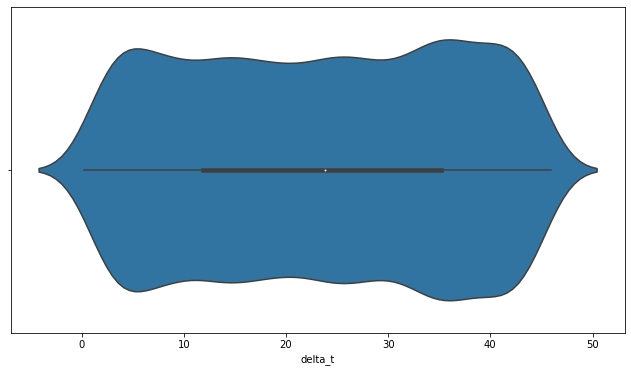

In [13]:
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=df, x="delta_t")

<AxesSubplot:xlabel='delta_t', ylabel='bagimli'>

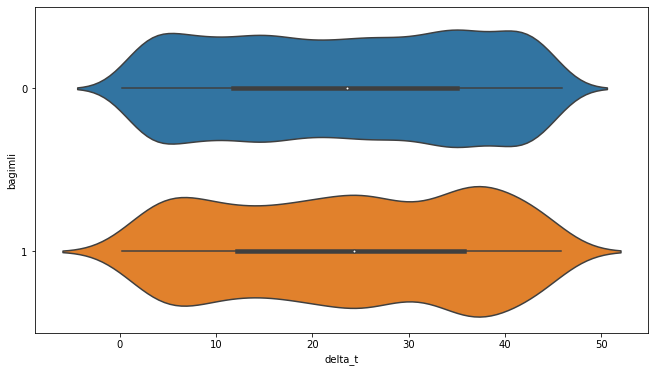

In [14]:
df_ = df.copy()
df_['bagimli'] = df_['bagimli'].astype(str)
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=df_, x="delta_t",y='bagimli')

# Model

In [15]:
display_all(df.head(2))
display_all(df.info())

,se_date,eq_time,eq_lat,eq_lon,flag_deprem_kontrol_1,flag_icinde,nn_lat,nn_lon,distance_km,bagimli,delta_t
0,1952-02-25,1952-02-28 00:34:06,-12.900,66.206,1,False,16.717778,34.584444,4784.148029,0,3.023681
1,1952-02-25,1952-03-02 18:52:57,11.303,-86.239,1,False,0.251667,-14.650556,7990.592495,0,6.786771


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   se_date                7172 non-null   datetime64[ns]
 1   eq_time                7172 non-null   datetime64[ns]
 2   eq_lat                 7172 non-null   float64       
 3   eq_lon                 7172 non-null   float64       
 4   flag_deprem_kontrol_1  7172 non-null   int64         
 5   flag_icinde            7172 non-null   bool          
 6   nn_lat                 7172 non-null   float64       
 7   nn_lon                 7171 non-null   float64       
 8   distance_km            7171 non-null   float64       
 9   bagimli                7172 non-null   int32         
 10  delta_t                7172 non-null   float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int32(1), int64(1)
memory usage: 539.4 KB


None

In [16]:
df.bagimli.value_counts(True)

0    0.81609
1    0.18391
Name: bagimli, dtype: float64

In [17]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score, recall_score, jaccard_score

In [18]:
import sklearn

In [19]:
sklearn.metrics.SCORERS.keys()
#https://stephenallwright.com/micro-vs-macro-f1-score/

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [20]:
#sklearn.metrics.SCORERS.values()

In [21]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

## Logistic Reg

In [106]:
X, y = df.delta_t.to_numpy().reshape(-1,1), df.bagimli.to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=1)

In [107]:
clf = LogisticRegression().fit(X_train, y_train)

predictions = clf.predict(X_test)
predictions = pd.DataFrame(predictions,columns=['tahmin'])

print(predictions.tahmin.value_counts())
print(predictions.tahmin.value_counts(True))

0    2152
Name: tahmin, dtype: int64
0    1.0
Name: tahmin, dtype: float64


## MinMaxScaler, test_size=.3

In [30]:
# Train-test ayırma
X, y = df.delta_t.to_numpy().reshape(-1,1), df.bagimli.to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=1, stratify=y)

#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)

In [31]:
# Hiperparametreler
param_grid = [{'estimator':[LogisticRegression(fit_intercept=True, solver='lbfgs',
                                               max_iter=1000,n_jobs=-1,random_state=1)],
               'estimator__penalty':['none','l1','l2','elasticnet'],
               'estimator__l1_ratio':[None, 1e-3, .01, .1, .5, 1],
               'estimator__C':[.01, .1, 1, 10, 100]},
              
              {'estimator': [RidgeClassifier(fit_intercept=True,max_iter=1000,random_state=1)],
               'estimator__alpha':[1e-3, .01, .1, 1,5],
               'estimator__tol':[1e-6, 1e-3, .01, .1]},
             
              {'estimator':[SVC(max_iter=1000,random_state=1)],
               'estimator__C':[.01, .1, 1, 10, 1000],
               'estimator__kernel':['linear','rbf','poly'],
               'estimator__degree':[1,2,3,4,5],
               'estimator__tol':[1e-5, 1e-3, .01, .1]},
              
              {'estimator':[KNeighborsClassifier()],
               'estimator__n_neighbors':[5,10,20,30],
               'estimator__weights':['uniform','distance'],
               'estimator__p':[1,2,3],
               'estimator__leaf_size':[20,30,50]},
              
              {'estimator':[GaussianNB()]},
              
              {'estimator':[RandomForestClassifier(n_jobs=-1,random_state=1)],
               'estimator__max_depth':[2,5,10,15],
               'estimator__min_samples_leaf':[1,5,10]}
              ]

pipe = Pipeline(steps=[('estimator', DummyEstimator())],
                verbose=False)

In [32]:
sonuc = pd.DataFrame()
cmx = pd.DataFrame()
sayac = 0

for parameter in param_grid:
    best_model = []
    search = RandomizedSearchCV(estimator=pipe,param_distributions=parameter,
                                n_iter=100,n_jobs=-1,random_state=1,
                                cv=2,#https://stackoverflow.com/questions/51944281/how-to-correctly-implement-stratifiedkfold-with-randomizedsearchcv
                                scoring='f1_macro',
                                return_train_score=True,
                                verbose=1)
    best_model = search.fit(X_train_,y_train)
    
    title = str(best_model.best_params_['estimator'])
    print('*'*100)
    print(title)
    print('*'*100)
    print('best_score_: ',best_model.best_score_,'\n')
    #print('best_estimator_: ',best_model.best_estimator_,'\n')
    #print('best_params_: ',best_model.best_params_,'\n')
    print('best_index_: ',best_model.best_index_,'\n')
    
    
    # Tahminler

    #clf = MLPClassifier(activation='relu', solver='sgd', learning_rate_init=0.2, tol=0.2, alpha=0.01)
    clf = best_model.best_params_['estimator']
    clf.fit(X_train_, y_train)
    
    
    #y_test_idx = y_test.index

    y_test_pred = clf.predict(X_test_)
    y_test_pred = pd.DataFrame(y_test_pred,columns=['tahmin'])
    #y_test_pred = y_test_pred.set_index(y_test_idx)
    
    print(classification_report(y_test, y_test_pred))#, target_names=labels))
    print('\n')
    
    acc_score = f1_score(y_test, y_test_pred,average='macro')
    
    sayac += 1
    sonuc_ = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).transpose()#target_names=labels, 
    sonuc_['macro_f1'] = acc_score
    sonuc_['param'] = title
    sonuc_['param_code'] = sayac
    sonuc = sonuc.append(sonuc_, ignore_index=False)
    
    #labels_tahmin = ['tahmin_Deplasman', 'tahmin_Beraberlik', 'tahmin_EvSahibi']
    #labels_gercek = ['gercek_Deplasman', 'gercek_Beraberlik', 'gercek_EvSahibi']
    cmx_ = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_test_pred),columns=['tahmin_0','tahmin_1'])#,index=labels_gercek)
    cmx_.index = ['gercek_0','gercek_1']
    cmx_['accuracy_score'] = acc_score
    cmx_['param'] = title
    cmx_['param_code'] = sayac
    cmx = cmx.append(cmx_, ignore_index=False)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
****************************************************************************************************
LogisticRegression(C=1, l1_ratio=0.001, max_iter=1000, n_jobs=-1,
                   random_state=1)
****************************************************************************************************
best_score_:  0.4493767742599901 

best_index_:  1 

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1756
           1       0.00      0.00      0.00       396

    accuracy                           0.82      2152
   macro avg       0.41      0.50      0.45      2152
weighted avg       0.67      0.82      0.73      2152



Fitting 2 folds for each of 20 candidates, totalling 40 fits
****************************************************************************************************
RidgeClassifier(alpha=0.001, max_iter=1000, random_state=1, tol=1e-06)
*******************

#### Model Sonuçları

In [33]:
cmx

,tahmin_0,tahmin_1,accuracy_score,param,param_code
gercek_0,1756,0,0.449335,"LogisticRegression(C=1, l1_ratio=0.001, max_it...",1
gercek_1,396,0,0.449335,"LogisticRegression(C=1, l1_ratio=0.001, max_it...",1
gercek_0,1756,0,0.449335,"RidgeClassifier(alpha=0.001, max_iter=1000, ra...",2
gercek_1,396,0,0.449335,"RidgeClassifier(alpha=0.001, max_iter=1000, ra...",2
gercek_0,1487,269,0.494079,"SVC(C=0.1, degree=4, kernel='poly', max_iter=1...",3
gercek_1,339,57,0.494079,"SVC(C=0.1, degree=4, kernel='poly', max_iter=1...",3
gercek_0,1537,219,0.493018,"KNeighborsClassifier(leaf_size=20, p=1, weight...",4
gercek_1,349,47,0.493018,"KNeighborsClassifier(leaf_size=20, p=1, weight...",4
gercek_0,1756,0,0.449335,GaussianNB(),5
gercek_1,396,0,0.449335,GaussianNB(),5


# Karar Model SVM: 4.3.2.1: SVC(C=0.1, degree=4, kernel='poly', max_iter=1000, random_state=1, tol=0.01)

In [129]:
# Train-test ayırma
X, y = df.delta_t.to_numpy().reshape(-1,1), df.bagimli.to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=1, stratify=y)

#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)

clf = SVC(C=0.1, degree=4, kernel='poly', max_iter=1000, random_state=1, tol=0.01).fit(X_train_, y_train)

predictions = clf.predict(X_test_)
predictions = pd.DataFrame(predictions,columns=['tahmin'])

print(predictions.tahmin.value_counts().sort_index())
print(predictions.tahmin.value_counts(True).sort_index())
print(predictions.shape)

0    1826
1     326
Name: tahmin, dtype: int64
0    0.848513
1    0.151487
Name: tahmin, dtype: float64
(2152, 1)


In [130]:
gercek = pd.DataFrame(y_test)
gercek.columns = ['gercek']
print(gercek.shape)

(2152, 1)


In [140]:
final = pd.concat([gercek,predictions],axis=1,ignore_index=False)
final['hata'] = final['gercek']-final['tahmin']
final.head()

,gercek,tahmin,hata
0,0,0,0
1,0,0,0
2,1,0,1
3,0,0,0
4,0,0,0


## Autocorrelation 

In [141]:
from statsmodels.tsa.stattools import acf
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html

In [189]:
df_acf = pd.DataFrame(acf(final['hata'],qstat=True)).T[1:-1]
df_acf.columns = ['acf','ljung_box_q','pvalue']
display_all(df_acf.head(2))
display_all(df_acf.tail(2))

,acf,ljung_box_q,pvalue
1,0.012748,1.097797,0.577586
2,-0.018621,1.451123,0.693596


,acf,ljung_box_q,pvalue
31,0.032668,28.765624,0.631040
32,-0.001949,29.042799,0.664593


<AxesSubplot:>

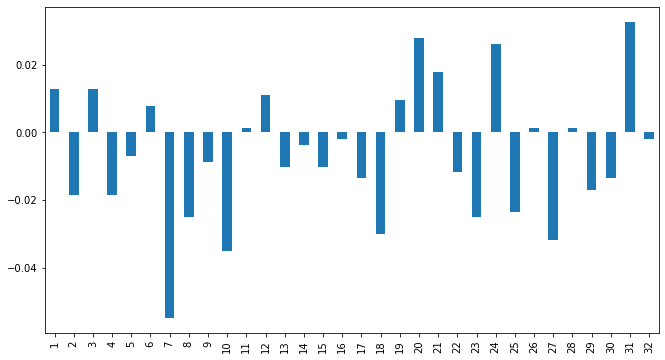

In [190]:
f, ax = plt.subplots(figsize=(11, 6))
df_acf['acf'].plot(kind='bar')